In [1]:
import yfinance as yf
import pandas as pd
import datetime

# Fetching S&P 500 Data using Yahoo Finance API

In [2]:
sp500 = yf.Ticker("^GSPC")

In [3]:
sp500 = sp500.history(period='max')

In [4]:
del sp500['Dividends']
del sp500['Stock Splits']

<Axes: xlabel='Date'>

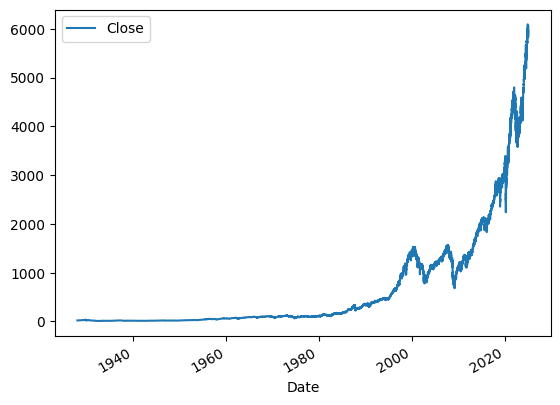

In [5]:
sp500.plot.line(y='Close',use_index=True)

In [6]:
# Create tomorrow column by using next day close value
sp500['Tomorrow'] = sp500["Close"].shift(-1)

In [7]:
# Create target column by compare tomorrow and close values
sp500["Target"] = (sp500["Tomorrow"]>sp500["Close"]).astype(int)

In [8]:
sp500.index = sp500.index.date

In [9]:
sp500

,Open,High,Low,Close,Volume,Tomorrow,Target
1927-12-30,17.660000,17.660000,17.660000,17.660000,0,17.760000,1
1928-01-03,17.760000,17.760000,17.760000,17.760000,0,17.719999,0
1928-01-04,17.719999,17.719999,17.719999,17.719999,0,17.549999,0
1928-01-05,17.549999,17.549999,17.549999,17.549999,0,17.660000,1
1928-01-06,17.660000,17.660000,17.660000,17.660000,0,17.500000,0
...,...,...,...,...,...,...,...
2025-01-14,5859.270020,5871.919922,5805.419922,5842.910156,4142280000,5949.910156,1
2025-01-15,5905.209961,5960.609863,5905.209961,5949.910156,4544570000,5937.339844,0
2025-01-16,5963.609863,5964.689941,5930.720215,5937.339844,4285810000,5996.660156,1
2025-01-17,5995.399902,6014.959961,5978.439941,5996.660156,4366830000,6049.240234,1


In [10]:
sp500 = sp500.loc[datetime.date(1990, 1, 1):].copy()

In [11]:
# Machine Learning

from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators = 100, min_samples_split = 100, random_state=42)

train = sp500.iloc[:-110]
test = sp500.iloc[-110:]

predictors = ["Close", "Volume", "Open", "High", "Low"]
model.fit(train[predictors], train["Target"])

RandomForestClassifier(min_samples_split=100, random_state=42)

In [12]:
from sklearn.metrics import precision_score

preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)
result = precision_score(test["Target"], preds)
result

0.5671641791044776

<Axes: >

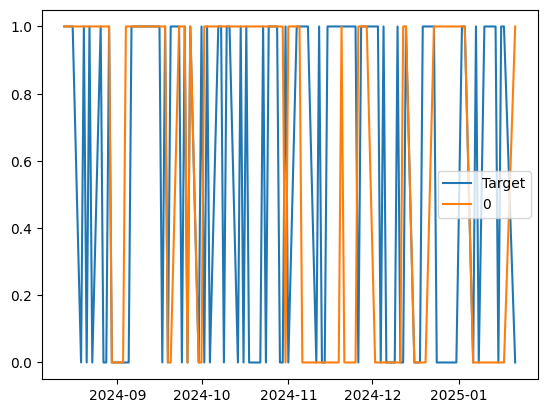

In [28]:
# Visualize and comapre the predictions and target variables
combined = pd.concat([test["Target"],preds],axis=1)
combined.plot()

In [14]:
def predict(train, test, predictors, model):
  model.fit(train[predictors],train["Target"])
  preds = model.predict(test[predictors])
  preds = pd.Series(preds, index=test.index, name="Predictions")
  combined = pd.concat([test["Target"],preds],axis=1)
  return combined

In [15]:
def backtest(data, model, predictors, start=2500, step=250):
  all_predictions = []

  for i in range(start, data.shape[0],step):
    train = data.iloc[0:i].copy()
    test = data.iloc[i:(i+step)].copy()

    predictions = predict(train, test, predictors, model)
    all_predictions.append(predictions)
  return pd.concat(all_predictions)

In [16]:
predictions = backtest(sp500, model, predictors)

In [17]:
predictions


,Target,Predictions
1999-11-22,0,0
1999-11-23,1,0
1999-11-24,0,0
1999-11-26,0,0
1999-11-29,0,0
...,...,...
2025-01-14,1,0
2025-01-15,0,1
2025-01-16,1,1
2025-01-17,1,1


In [18]:
predictions["Predictions"].value_counts()

,count
Predictions,
0,3547
1,2782


In [19]:
precision_score(predictions["Target"],predictions["Predictions"])

0.5301941049604602

In [20]:
predictions["Target"].value_counts() / predictions.shape[0]

,count
Target,
1,0.536104
0,0.463896


In [21]:
# Add predictors

horizons = [2, 5, 60, 250, 1000]

new_predictors = []

for horizon in horizons:
  rolling_averages = sp500.rolling(horizon).mean()

  ratio_column = f"Close_Ratio_{horizon}"
  sp500[ratio_column] = sp500["Close"] / rolling_averages["Close"]

  trend_column = f"Trend_{horizon}"
  sp500[trend_column] = sp500.shift(1).rolling(horizon).sum()["Target"]

  new_predictors += [ratio_column, trend_column]

In [22]:
sp500 = sp500.dropna()

In [23]:
model = RandomForestClassifier(n_estimators = 200, min_samples_split=50, random_state = 42)

In [24]:
def predict(train, test, predictors, model):
  model.fit(train[predictors],train["Target"])
  preds = model.predict_proba(test[predictors])[:,1]
  preds[preds >= .6] =1
  preds[preds < .6] =0
  preds = pd.Series(preds, index=test.index, name="Predictions")
  combined = pd.concat([test["Target"],preds],axis=1)
  return combined

In [25]:
predictions = backtest(sp500, model, new_predictors)

In [26]:
predictions["Predictions"].value_counts()

,count
Predictions,
0.0,4516
1.0,812


In [27]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5775862068965517

After addiing the 2, 5, 60, 250, 1000 days related predictors, the precision score increase from 0.530 to 0.578 which improve 9%.